<a href="https://colab.research.google.com/github/belbelbel/Emo-Sentimen-Analysis/blob/main/Sentimen_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import csv
import re
import tensorflow
import string
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Layer, Input, Dense, LSTM, Embedding, Dropout
from keras.models import load_model

In [31]:
df = pd.read_csv('/content/drive/MyDrive/Sentimen Analysis/CSV with sentimen.csv')
df

,image_name,pred
0,0,Seorang pria dengan ekspresi marah sedang minu...
1,0,Seorang pria minum bir dengan tatapan marah.
2,0,Seorang pria yang tampak marah dengan seekor S...
3,0,"Seorang wanita mengenakan gaun merah, sorban, ..."
4,0,Seorang wanita yang berpakaian merah membuat w...
...,...,...
917,6,Seorang anak laki -laki dengan piyama Natal hi...
918,6,Seorang anak laki -laki di piyama cetak Natal ...
919,6,Seorang anak laki -laki membuka hadiah Natal.
920,6,Orang kulit hitam di kamar mandi rumah dengan ...


In [32]:
with open('/content/drive/MyDrive/Sentimen Analysis/CSV with sentimen.csv', 'r') as f:
    next(f)
    all_csv = f.read()

In [34]:
sentimen = {}
for line in tqdm(all_csv.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue

    id, caption = tokens[0], tokens[1:]
    id = id.split('.')[0]

    caption = " ".join(caption)

    if id not in sentimen:
        sentimen[id] = []

    sentimen[id].append(caption)

  0%|          | 0/923 [00:00<?, ?it/s]

In [35]:
len(sentimen)

7

In [47]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]

            #tambahan cleaning
            clear = str.maketrans('', '', string.punctuation)
            caption = caption.translate(clear)
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = '<start> ' + " ".join([word for word in caption.split() if len(word)>1]) + ' <end>'

            captions[i] = caption

In [48]:
clean(sentimen)

In [ ]:
sentimen

In [50]:
all_text = []

for key, values in sentimen.items():
  for txt in values:
    all_text.append(txt)

In [51]:
len(all_text)

922

In [52]:
tokenizer = Tokenizer(num_words=10000, oov_token='OOV')
tokenizer.fit_on_texts(all_text)
vocab_size = len(tokenizer.word_index) + 1

In [53]:
vocab_size

1235

In [54]:
max_length = max(len(caption.split()) for caption in all_text)
max_length

62

In [83]:
from sklearn.model_selection import train_test_split

In [84]:
train, test = train_test_split(df, test_size=0.01)

In [85]:
train_seq = tokenizer.texts_to_sequences(train['pred'])

In [93]:
X_train = pad_sequences(train_seq, maxlen=max_length)
y_train = train['image_name']
Y_train = to_categorical(y_train, num_classes=7)

In [94]:
from keras.layers.serialization import activation
capt1 = Input(shape=(max_length,))
capt2 = Embedding(vocab_size, 300, mask_zero=True)(capt1)
capt3 = Dropout(0.25)(capt2)

lstm1 = LSTM(128)(capt3)
lstm2 = Dense(128, activation='relu')(lstm1)
lstm3 = Dropout(0.25)(lstm2)
lstm4 = Dense(7, activation='softmax')(lstm3)

model = Model(inputs=capt1, outputs=lstm4)

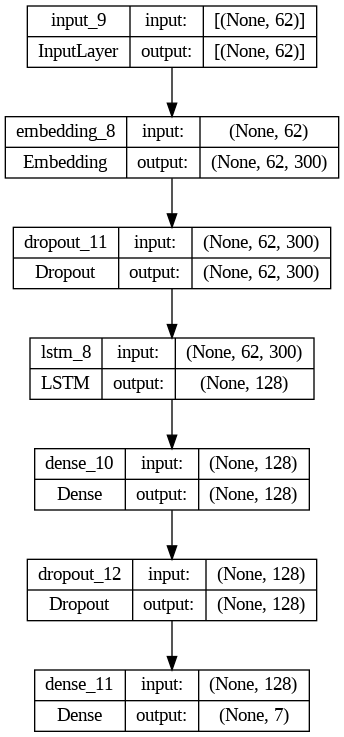

In [95]:
tensorflow.keras.utils.plot_model(model, show_shapes=True)

In [96]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [97]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 62)]              0         
                                                                 
 embedding_8 (Embedding)     (None, 62, 300)           370500    
                                                                 
 dropout_11 (Dropout)        (None, 62, 300)           0         
                                                                 
 lstm_8 (LSTM)               (None, 128)               219648    
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 7)                 903 

In [98]:
bs = 32

his1 = model.fit(X_train, Y_train, epochs=10, batch_size=bs, verbose=1)

Epoch 1/10
29/29 [==============================] - 13s 279ms/step - loss: 1.1134 - accuracy: 0.8355
Epoch 2/10
29/29 [==============================] - 6s 202ms/step - loss: 0.4145 - accuracy: 0.8772
Epoch 3/10
29/29 [==============================] - 6s 206ms/step - loss: 0.2587 - accuracy: 0.9156
Epoch 4/10
29/29 [==============================] - 7s 250ms/step - loss: 0.1863 - accuracy: 0.9375
Epoch 5/10
29/29 [==============================] - 6s 196ms/step - loss: 0.1427 - accuracy: 0.9408
Epoch 6/10
29/29 [==============================] - 8s 269ms/step - loss: 0.1099 - accuracy: 0.9594
Epoch 7/10
29/29 [==============================] - 6s 198ms/step - loss: 0.0946 - accuracy: 0.9572
Epoch 8/10
29/29 [==============================] - 9s 297ms/step - loss: 0.0865 - accuracy: 0.9704
Epoch 9/10
29/29 [==============================] - 5s 189ms/step - loss: 0.0634 - accuracy: 0.9803
Epoch 10/10
29/29 [==============================] - 7s 261ms/step - loss: 0.0387 - accuracy: 0.990

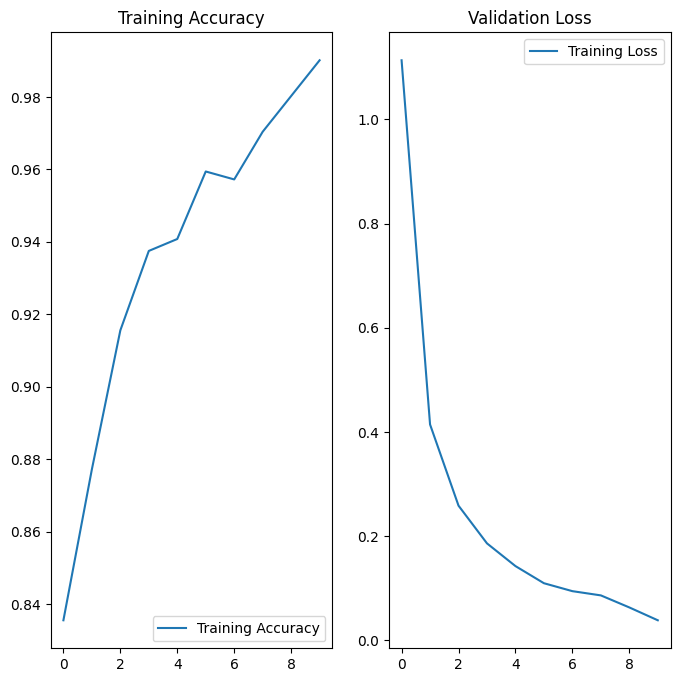

In [99]:
acc = his1.history['accuracy']
loss = his1.history['loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Validation Loss')
plt.show()

In [101]:
emo = {0: 'marah', 1: 'jijik', 2: 'takut', 3: 'bahagia', 4: 'sedih', 5: 'terkejut', 6: 'netral'}

In [102]:
capts = ['anak kecil bermain layangan']
capts =  tokenizer.texts_to_sequences(capts)
capts = pad_sequences(capts, maxlen=max_length)

res_predict = model.predict(capts)
pred = np.argmax(res_predict)
preds = emo[pred]

preds

1/1 [==============================] - 2s 2s/step


'bahagia'